# Introduction
This is a brief tutorial that guides you to make good use of music data, mainly lyrics. 

Most people like me love music. We listen to music every day, and it seems that we know much about it. However, it does not acutually. Most of us care only about the songs they listen. Thus, usually we do not catch the whole picture of the modern music world even though thousands of songs are being generating every year. One of the most popular chart is the Billboard Hot100, through which we know the style tread in these days. Here I want to make it as an example, developing a pipeline to have all the lyrics data we need to do more advanced data analysis later.

During the following short but detailed steps, I will show you how to collect lyrics data (more quickly) from Billboard Hot100 Charts within half a century before you can preprocess the raw lyrics with basic or advanced natural language processing techniques, to visualize the clean lyrics using statistic methods, or even you will make some fun of them, that is, write a song of lyrics that matches the trend of Hot 100.

![alt text](https://www.billboard.com/files/media/hot100.svg)

# content
Step by step, I will demonstrate the procedure of basic data collection, and some basic data analysis in Python3. I will use some modules such as BeautifulSoup, matplotlib, etc.

I am going to use chart data collected from [Billboard the Hot 100](https://www.billboard.com/charts/hot-100) during the last 50 years. Then lyrics will be scraped from https://genius.com/, which is a public repository for large amount of song data. 

Topics will be covered in this tutorial as following:


*   [Installing the libraries](#Installing-the-libraries)
*   [Scraping charts data from Billboard.com](#Scraping-Charts-Data-from-Billboard.com)
*   [Fetching lyrics data from Genius.com](#Fetching-lyrics-data-from-Genius.com)
*   [Collecting all HOT100 lyrics during last 50 years!](#Collecting-all-HOT100-lyrics-during-last-50-years!)
*   [Data visualization of lyrics data](#Data-visualization-of-lyrics-data)
*   [Generating the HOTTEST lyrics in Billboard](#Generating-the-HOTTEST-lyrics-in-Billboard)
*   [Summary and references](#Summary-and-references)

# Installing the libraries
In this tutorial, basic modules would be used. We can simply using conda or pip to install all we need. Such as:


```bash
$ pip install --upgrade matplotlib bs4
```
or


```bash
$ conda install matplotlib bs4
```

We can check the available modules in our running environment by running command: *pip list* or *conda list*




After installation, make sure you can import all the modules in the following:


In [4]:
import re, requests, os, json
from bs4 import BeautifulSoup

# Scraping Charts Data from Billboard.com

Everything's ready. Let's get started.

First things first, as for the principle of OOD, we're going to construct a class named BillboardChart to store  songs of the Hot 100 chart every week as well as a basic Song class. Here are the class Song full codes and the skeleton of class BillboardChart:





In [5]:
class Song():

    def __init__(self, title, artist, lyrics):
        """
        simple song class to store basic info of a song
        Args:
            title: string, name of the song
            artist: string, name(s) of the singer
            lyrics: string, lyrics words seperated by spaces
        """
        self.song_info = {}
        self.song_info['title'] = title
        self.song_info['artist'] = artist
        self.song_info['lyrics'] = lyrics

In [6]:
# This code is meant as an overview, not meant to compile
'''
class BillboardChart:

    def __init__(self, chart_name='hot-100', date=None):

        self.chart_name = chart_name
        self.date = date
        self.songs = []
        self.valid_lyrics_num = 0

    def load_chart_songs(self):

        url = 'http://www.billboard.com/charts/%s/%s' % (self.chart_name, self.date)
        bb_soup = ...
        for i, one_soup in enumerate(bb_soup):
            title = title_raw[1].string.strip()
            artist = title_raw[3].a.string.strip()
            lyrics = get_lyrics_from_title_and_artist(title, artist)
            if lyrics:
                self.valid_lyrics_num += 1
            song = Song(title, artist, lyrics)
            self.songs.append(song)
'''


"\nclass BillboardChart:\n\n    def __init__(self, chart_name='hot-100', date=None):\n\n        self.chart_name = chart_name\n        self.date = date\n        self.songs = []\n        self.valid_lyrics_num = 0\n\n    def load_chart_songs(self):\n\n        url = 'http://www.billboard.com/charts/%s/%s' % (self.chart_name, self.date)\n        bb_soup = ...\n        for i, one_soup in enumerate(bb_soup):\n            title = title_raw[1].string.strip()\n            artist = title_raw[3].a.string.strip()\n            lyrics = get_lyrics_from_title_and_artist(title, artist)\n            if lyrics:\n                self.valid_lyrics_num += 1\n            song = Song(title, artist, lyrics)\n            self.songs.append(song)\n"

With these two classes, we can get all the songs information by simply calling:


```python
chart_hot100_20180317 = BillboardChart(chart_name='hot-100', date='2018-03-17')
chart_hot100_20180317.load_chart_songs()
```


Then we can fulfill our BillboardChart class skeleton one by one.
## \__init__

Class BillboardChart has four attributes right now:


1.   chart_name: only 'hot-100' will be used in the whole tutorial
2.   date: we will iterate every date of Saturday during the last 50 years
3.   songs: list of objects of Song
4.   valid_lyrics_num: since some lyrics data might be missing, or we couldn't match the title and the artist in some situation, some songs might contains lyrics of None, and here we count the valid number of lyrics for further analysis.


In our tasks, we need to ensure that the date formats are valid so that we can get charts from Billboard Hot 100. Therefore, before passing the date, we check its format using regular expression.

```python
if date and not re.match('\d{4}-\d{2}-\d{2}', str(date)):
    print('Wrong Date Format. Correct Format: YYYY-MM-DD')
```

## load_chart_songs
By calling this function once, we get one Billboard chart of 100 songs including their titles, artists and lyrics. Then we can use all the data for analysis. Here are the methods I use to handle the lyrics scraping.

### First, 
in case that no date is input, the latest chart would be loaded. For example, https://www.billboard.com/charts/hot-100 shows us the latest chart web page, while https://www.billboard.com/charts/hot-100/2018-03-10 displays the chart on 2018-03-10.
### Second,
we would scrape the raw content of a html page from a url. Since we're going to get them several times, we build a simple function here:

In [7]:
def get_raw_content_from_url(url):
    """

    Args:
        url: string starts with 'http://'

    Returns: string of raw text of the html page

    """
    assert url.startswith('http://')
    response = requests.get(url=url)
    if response.status_code == 200:
        response.encoding = 'utf-8'
        return response.text
    else:
        return 'get nothing from this html'

By calling this function, we get the raw text of the page. Then we can utilize BeautifulSoup tool to parse the html page. Remember, checking the "inspect" of the page by right clicking the page usually helps us find the elements of our targets. Since my codes are straightforward, I will just directly show the codes here to illustrate the parsing process. Then we get a more complete version of class BillboardChart.

In [8]:
class BillboardChart:

    def __init__(self, chart_name='hot-100', date=None):
        """
        simple billboard chart to store chart name and the specific date
        Args:
            chart_name: string, here we specify 'hot-100' for our purpose
            date: string, valid format is 'YYYY-MM-DD'
        """

        self.chart_name = chart_name

        if date and not re.match('\d{4}-\d{2}-\d{2}', str(date)):
            print('Wrong Date Format. Correct Format: YYYY-MM-DD')
            self.date = None
        else:
            self.date = date
        self.songs = []
        self.valid_lyrics_num = 0

    def load_chart_songs(self):

        if not self.date: url = 'http://www.billboard.com/charts/%s' % (self.chart_name)
        else: url = 'http://www.billboard.com/charts/%s/%s' % (self.chart_name, self.date)

        bb_page = get_raw_content_from_url(url)
        bb_soup = BeautifulSoup(bb_page, 'html.parser').find_all('article', {'class': 'chart-row'})

        title_and_artist = []
        for i, one_soup in enumerate(bb_soup):
            title_raw = one_soup.find('div', 'chart-row__title').contents
            try:
                title = title_raw[1].string.strip()
            except:
                print('get no title')
            try:
                if title_raw[3].find('a'):
                    artist = title_raw[3].a.string.strip()
                else:
                    artist = title_raw[3].string.strip()
            except:
                print('get no artist')

            print('#%s song: %s\tartist: %s' % (i + 1, title, artist))
            title_and_artist.append((i, title, artist))

        
        import multiprocessing as mp
        pool = mp.Pool(4)
        get_lyrics_jobs = [
            pool.apply_async(get_lyrics_from_title_and_artist,
                             args=(i, title, artist))
            for i, title, artist in title_and_artist
        ]
        songs = [j.get() for j in get_lyrics_jobs]
        for i, title, artist, lyrics in songs:
            if lyrics:
                self.valid_lyrics_num += 1
            song = Song(title, artist, lyrics)
            self.songs.append(song.song_info)

            # print('#%s song: %s\tartist: %s' % (i + 1, title, artist))

Right now, we get each song name and its artist name by scanning every hot100 page on the days we need. But the most important thing we still have not is the lyrics data. The only thing we need to complete the full class BillboardChart is function **get_lyrics_from_title_and_artist**. We're going to implement it in the next step.

By the way, I accelerate my naive spider a little bit by using **multiprocessing**. Using multiprocessing can obviously boost your program about three times as fast as the normal single processing program based on CPUs on your computer. However, we have much more promising methods for speeding up the scraping process, such as asyncio, aiohttp or 3rd party module like scrapy etc. Feel free to try them. More see References.

# Fetching lyrics data from Genius.com
Luckily, Genius.com provides us with simple but powerful **ReSTful** api as well as database of enough songs to explore. We can get lyrics easily from Genius by using its API. I plan to divide the fetching process into two main parts. 1st is getting the api path by passing the title and artist name of the song. 2nd is scraping the clean lyrics by having the song's api path.

In [9]:
def get_lyrics_from_title_and_artist(i, title, artist):
    song_api_path = get_song_api_path_from_title_and_artist(i, title, artist)
    lyrics = get_lyrics_from_api_path(song_api_path)
    return i, title, artist, lyrics

Then, we could use API from Genius.com to fetch lyrics more accurately.

## ReSTful API
Before using Genius API, we need to two more steps:
### Authentication & Generate API keys
Setup a Genius account if you do not have one and get API credentials. Please follow the latest instructions on https://genius.com/developers get the token.
### KEEP THE API KEY FILE/TOKEN PRIVATE AND OUT OF VERSION CONTROL
First, store your Genius credentials in a local file (kept out of version control) which you can read in to authenticate with the API. 

For example, you may want to store your key in a file called `token.txt` (run in terminal):
```bash
echo 'GENIUS_TOKEN' > token.txt
```

You can then read from the file using:
```python
with open('token.txt', 'r') as f:
    token = f.read().replace('\n','')
    # use your token
```

But in this tutorial I use environment variables instead. Simply calling the following functions gets me the key and the requests headers. 


In [10]:
# this code should be detroyed after running
# with open('token.txt', 'w') as f:
#     f.write('this is your token here')

In [11]:
def get_token(file_path):
    with open(file_path, 'r') as f:
        token = f.read().replace('\n','')
        return token

token = get_token('token.txt')
HEADERS = {'Authorization': 'Bearer %s' % (token)}

5Oucnd-RuL_qExoPjSDQ5PDsWwXxxzQf2PUbyHIKlUQUEpnE3e6lccOAbpe-X5D5


## get_song_api_path_from_title_and_artist(title, artist)

In this subtask, we will firstly using Genius Search API to HIT a list of song with the song title. Then by matching the name of artist with the hitting song artist name, finally we can get the exact same song unique number we need. Still, we have to face a problem that some song titles are not correctly spelled or some artists have their names strange and can never be correctly matched by regular rules. That's why we set up the valid_lyrics_num to count the 'real' song data. To improve the matching rate, we need to do some preprocessing job for both the artist names and the song titles.

Then we get the song api path like this: 


```link
/songs/3411476
```



In [12]:
def get_song_api_path_from_title_and_artist(i, title, artist):
    def pre_process_artist_name(artist):
        artist = artist.lower().replace("'s", "").replace("'", "").replace(" x ", " ")
        import string
        for punct in string.punctuation:
            artist = artist.replace(punct, ' ')
        return ' '.join(artist.split())

    def pre_process_title(title):
        return re.sub(r"""\(.*\)""", '', title)

    artist = pre_process_artist_name(artist)
    genius_search_url = 'http://api.genius.com/search'
    title = pre_process_title(title)
    query = {'q': title}
    response = requests.get(genius_search_url, headers=HEADERS, params=query).json()

    for hit in response['response']['hits']:
        hit_artist_name = hit['result']['primary_artist']['name']
        hit_artist_name = pre_process_artist_name(hit_artist_name)
        if hit_artist_name in artist or artist in hit_artist_name:
            song_api_path = hit['result']['api_path']
            return song_api_path
    return None

## get_lyrics_from_api_path(api_path)
To move forward, we now can pass the api path (e.g. /songs/3411476) to get the final lyrics. Similarly, we use Genius API fetch the real url of the song and then scrape the lyrics from html pages.

In [13]:
def get_lyrics_from_api_path(api_path):    
    if not api_path: return None
    song_api_url = 'http://api.genius.com' + api_path
    response = requests.get(song_api_url, headers=HEADERS).json()
    song_real_url = 'http://genius.com' + response['response']['song']['path']
    song_content = get_raw_content_from_url(song_real_url)
    song_soup = BeautifulSoup(song_content, 'html.parser')
    [s.extract() for s in song_soup('script')]
    lyrics = song_soup.find('div', class_='lyrics').get_text()
    return lyrics.replace('\n', ' ')

By the way, we need a helper function to list all the saturdays of one year so that we can iterate all 50 years' week HOT100 songs for lyrics. Here is the helper function:

In [14]:
def get_all_saturdays_before_this_week(year):
    from datetime import date, timedelta
    d = date(year, 1, 1)
    d += timedelta(days=5 - d.weekday())
    if d.year < year:
        d += timedelta(days=7)
    while d.year == year:
        yield str(d)
        if d - date.today() > timedelta(days=0):
            return
        d += timedelta(days=7)

# Collecting all HOT100 lyrics during last 50 years!
Finally, we have fully working codes to get all of lyrics. For demonstration, I set the year period from 2017 to 2018, and only get one weekly chart. But by changing the time from 1969 to 2019, you can definitely get almost all the song lyrics during the recent 50 years!

In [ ]:
# since years of data is huge, I have predownloaded 10 years of lyrics in path 'lyrics'
# the real predownloaded json lyrics files are in 'lyrics' path
if not os.path.exists('test'): os.mkdir('test')
songs_in_year50 = []
for year in range(1969, 2019):
    for i, week in enumerate(get_all_saturdays_before_this_week(year)):        
#         if os.path.exists('test/billboard_hot100_%s.json' % (week)):
#             continue
        print('\nweek - %s' % (week))
        songs_in_oneweek = BillboardChart(chart_name='hot-100', date=week)
        songs_in_oneweek.load_chart_songs()
        songs_in_year50.append(songs_in_oneweek)
        with open('test/billboard_hot100_%s.json' % (week), 'wt') as f:
            json.dump(songs_in_oneweek.songs, f, sort_keys=True, indent=4)
        valid_songs = songs_in_oneweek.valid_lyrics_num
        all_songs = len(songs_in_oneweek.songs)
        print('valid/all = %s/%s' % (valid_songs, all_songs))


week - 2017-01-07
#1 song: Starboy	artist: The Weeknd Featuring Daft Punk
#2 song: Black Beatles	artist: Rae Sremmurd Featuring Gucci Mane
#3 song: Closer	artist: The Chainsmokers Featuring Halsey
#4 song: 24K Magic	artist: Bruno Mars
#5 song: Juju On That Beat (TZ Anthem)	artist: Zay Hilfigerrr & Zayion McCall
#6 song: Side To Side	artist: Ariana Grande Featuring Nicki Minaj
#7 song: Let Me Love You	artist: DJ Snake Featuring Justin Bieber
#8 song: Don't Wanna Know	artist: Maroon 5 Featuring Kendrick Lamar
#9 song: Bad Things	artist: Machine Gun Kelly x Camila Cabello
#10 song: Fake Love	artist: Drake
#11 song: Caroline	artist: Amine
#12 song: Heathens	artist: twenty one pilots
#13 song: Bad And Boujee	artist: Migos Featuring Lil Uzi Vert
#14 song: Scars To Your Beautiful	artist: Alessia Cara
#15 song: Broccoli	artist: D.R.A.M. Featuring Lil Yachty
#16 song: All I Want For Christmas Is You	artist: Mariah Carey
#17 song: Starving	artist: Hailee Steinfeld & Grey Featuring Zedd
#18 song

By now, we have all the data we need for analysis. Congratulations!!! We can have a look at how the json file of a weekly chart of lyrics as following:
```json
[
    ...
    {
        "artist": "Bruno Mars", 
        "lyrics": "  [Intro] Tonight I just want to take you higher Throw your hands up in the sky Let's set this party off right...24 karat magic in the air Head to toe so player (24 karat) Uh, look out  [Outro] (24 karat magic, magic, magic)  ", 
        "title": "24K Magic"
    }, 
    {
        "artist": "Zay Hilfigerrr & Zayion McCall", 
        "lyrics": "  [Intro: Grandmother] Do that one dance baby That, ... You your daddy's son  ", 
        "title": "Juju On That Beat (TZ Anthem)"
    },
    ...
]
```

And here are part of our json lyrics files.
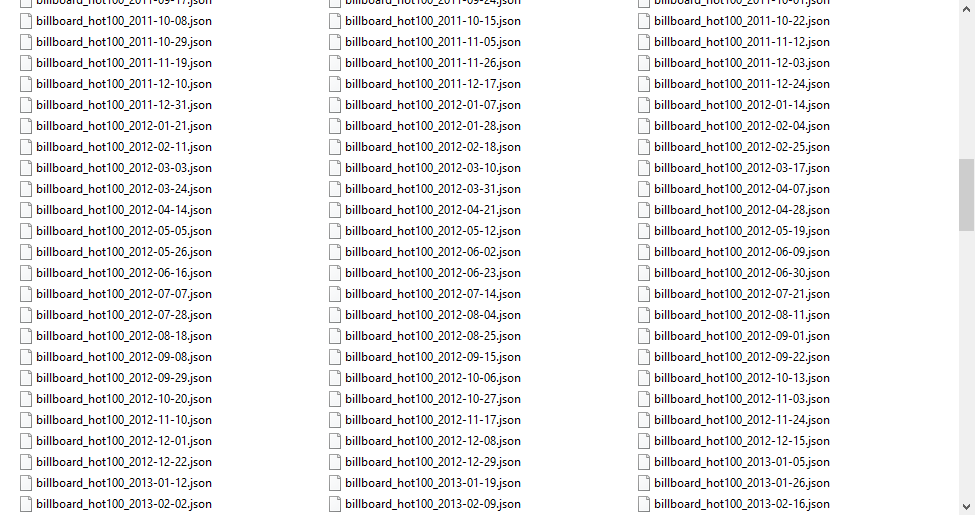

# Data visualization of lyrics data
Usually collecting data is the first as well as one of the most fructrating things to do of a data scientist's job. Since we have tons of lyrics here, we now can see the trend of the hottest lyrics these years on the billboard history.
## First 
Before make any conclusions, we should use some basic NLP techniques to preprocess the raw lyrics, such as removing meaningless words or punctuations from the lyrics. Then we can get the length and vocabulary information from the lyrics lists.

In [22]:
def get_songs(week):
    with open('lyrics/billboard_hot100_%s.json' % (week), 'rt') as f:
        songs_in_a_week = json.loads(f.read())
    return songs_in_a_week

def get_basic_stat_from_one_week_songs(week):
    songs_in_a_week = get_songs(week)
    text_corpus = []
    for song in songs_in_a_week:
        lyrics = song['lyrics']
        if not lyrics:
            text_corpus.append('')
            continue
        lyrics = lyrics.lower().strip().replace("'s", "").replace("'","")
        lyrics = re.sub(r"""\[.*?\]""", '', lyrics)
        import string
        for punct in string.punctuation:
            lyrics = lyrics.replace(punct, ' ')
        text_corpus.append(' '.join(lyrics.split()))
    # average length through weeks
    avg_length = sum([len(lyrics.split()) for lyrics in text_corpus]) / len(text_corpus)
    # average vocab through weeks
    avg_vocab = sum([len(set(lyrics.split())) for lyrics in text_corpus]) / len(text_corpus)
    return avg_length, avg_vocab, text_corpus

## Second
By drawing the plots, we can clearly observe that average lyrics length of songs gets longer and longer from 2009 to 2019. As well, the mean vocabulary become a little larger, though not so obvious.

Text(0,0.5,'average count')

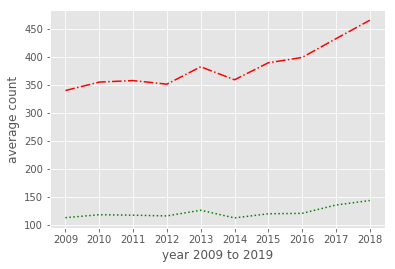

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

avg_length_s = []
avg_vocab_s = []
years = []

for year in range(2009, 2019):
    years.append(str(year))
    avg_length_s_in_a_year = []
    avg_vocab_s_in_a_year = []
    for week in get_all_saturdays_before_this_week(year):
        if not os.path.exists('lyrics/billboard_hot100_%s.json' % (week)):
            continue
        avg_length, avg_vocab, list_lyrics = get_basic_stat_from_one_week_songs(week)
        avg_length_s_in_a_year.append(avg_length)
        avg_vocab_s_in_a_year.append(avg_vocab)
    avg_length_s.append(sum(avg_length_s_in_a_year) / len(avg_length_s_in_a_year))
    avg_vocab_s.append(sum(avg_vocab_s_in_a_year) / len(avg_vocab_s_in_a_year))
plt.figure()
plt.plot(years, avg_length_s, color='red', label='average lengths of songs through years', linestyle='-.')
plt.plot(years, avg_vocab_s, color='green', label='average vocabs of songs through years', linestyle=':')
plt.xlabel('year 2009 to 2019')
plt.ylabel('average count')

# Generating the HOTTEST lyrics in Billboard
It's fun time finally. I decided to guide you readers to build a bigram language model based on which I can "write" a HOT100 song lyrics. But time's limited and words cannot be extended anymore to show more examples to you. So, help yourselves to use the collected 50-year corpus and make good use of it. 

Music world is beautiful and endless, and these lyrics resources are huge enough for music lovers to delve into them. Please make good use of the data and thanks!

# Summary and references

Most of the jobs in this tutorial is about collection of lyrics data. That's fine because it tedious and frustrating most of the time. So I am so happy to go over them here. And I believe that using these methods to collect data, you can accelerate your process to handle more analysis work and save time.

One more thing is that one of the main problems in this tutorial is that I still don't get a perfect way to get the lyrics by parsing title and artist, which leads to less valid data than real one for analysis, especially old songs. But we can still get the whole trend of the data since the total volume of lyrics is large enough.


More information can be referred from the following materials:


1.   Billboard HOT100 Weekly Charts: https://www.billboard.com/charts/hot-100
2.   Genius Developers: https://genius.com/developers
3.   Multiprocessing in Python: https://docs.python.org/3/library/multiprocessing.html
4.   Asyncio in Python: https://docs.python.org/3/library/asyncio.html
5.   Language Model from Assignment 3 of 15-688
6.   3rd Party Python API for Billboard Charts: https://github.com/guoguo12/billboard-charts

